Epoch 0, Loss: 0.6413
Epoch 100, Loss: 0.4560
Epoch 200, Loss: 0.4458
Epoch 300, Loss: 0.4433
Epoch 400, Loss: 0.4426
Epoch 500, Loss: 0.4421
Epoch 600, Loss: 0.4418
Epoch 700, Loss: 0.4415
Epoch 800, Loss: 0.4414
Epoch 900, Loss: 0.4413
Epoch 1000, Loss: 0.4413
Epoch 1100, Loss: 0.4411
Epoch 1200, Loss: 0.4409
Epoch 1300, Loss: 0.4408
Epoch 1400, Loss: 0.4406
Epoch 1500, Loss: 0.4405
Epoch 1600, Loss: 0.4404
Epoch 1700, Loss: 0.4403
Epoch 1800, Loss: 0.4402
Epoch 1900, Loss: 0.4401
Epoch 2000, Loss: 0.4401
Epoch 2100, Loss: 0.4400
Epoch 2200, Loss: 0.4399
Epoch 2300, Loss: 0.4398
Epoch 2400, Loss: 0.4398
Epoch 2500, Loss: 0.4397
Epoch 2600, Loss: 0.4396
Epoch 2700, Loss: 0.4397
Epoch 2800, Loss: 0.4396
Epoch 2900, Loss: 0.4396
Epoch 3000, Loss: 0.4396
Epoch 3100, Loss: 0.4396
Epoch 3200, Loss: 0.4395
Epoch 3300, Loss: 0.4394
Epoch 3400, Loss: 0.4394
Epoch 3500, Loss: 0.4393
Epoch 3600, Loss: 0.4393
Epoch 3700, Loss: 0.4392
Epoch 3800, Loss: 0.4392
Epoch 3900, Loss: 0.4392
Epoch 4000, 

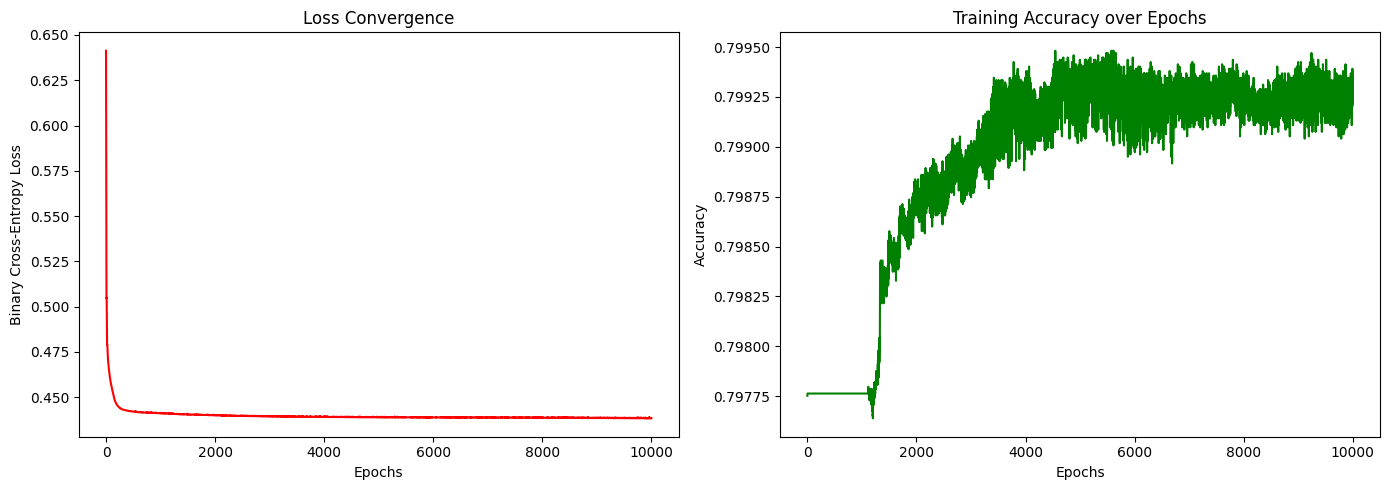

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, f1_score, precision_recall_curve, auc, confusion_matrix
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import psutil
import os

df=pd.read_csv(r'C:\Users\ravik\Downloads\noshowdataset\KaggleV2-May-2016.csv')

df['No-show'] = df['No-show'].map({'No': 0, 'Yes': 1})
df['ScheduledDay'] = pd.to_datetime(df['ScheduledDay'])
df['AppointmentDay'] = pd.to_datetime(df['AppointmentDay'])
df['DayGap'] = (df['AppointmentDay'] - df['ScheduledDay']).dt.days


df['Gender'] = LabelEncoder().fit_transform(df['Gender'])
df['Handcap'] = df['Handcap'].apply(lambda x: 1 if x > 0 else 0)

df.drop(['PatientId', 'AppointmentID', 'ScheduledDay', 'AppointmentDay', 'Neighbourhood'], axis=1, inplace=True)

X = df.drop('No-show', axis=1).values
y = df['No-show'].values

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.reshape(-1, 1), dtype=torch.float32)


class Net(nn.Module):
    def __init__(self, input_dim):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_dim, 32)
        self.fc2 = nn.Linear(32, 8)
        self.out = nn.Linear(8, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.out(x))
        return x

model = Net(X_train.shape[1])
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

epochs = 10000
loss_history = []
acc_history = []


start_time = time.time()
process = psutil.Process(os.getpid())
mem_before = process.memory_info().rss / (1024 ** 2)
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    loss_history.append(loss.item())
    acc = accuracy_score(y_train, (outputs.detach().numpy() > 0.5).astype(int))
    acc_history.append(acc)

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

end_time = time.time()
train_time = end_time - start_time

# Evaluate
model.eval()
with torch.no_grad():
    y_pred_prob = model(X_val_tensor).numpy().flatten()
    y_pred = (y_pred_prob > 0.5).astype(int)

acc = accuracy_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
precision, recall, _ = precision_recall_curve(y_val, y_pred_prob)
pr_auc = auc(recall, precision)
cm = confusion_matrix(y_val, y_pred)
mem_after = process.memory_info().rss / (1024 ** 2)
mem_used = mem_after - mem_before

print("\n For PyTorch Model Evaluation ")
print(f"Training Time: {train_time:.2f} seconds")
print(f"Accuracy: {acc:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"PR-AUC: {pr_auc:.4f}")
print("Confusion Matrix:\n", cm)
print(f"Memory used: {mem_used:.2f} MB")

# Plotting loss and accuracy
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(loss_history, color='red')
plt.title('Loss Convergence')
plt.xlabel('Epochs')
plt.ylabel('Binary Cross-Entropy Loss')

plt.subplot(1, 2, 2)
plt.plot(acc_history, color='green')
plt.title('Training Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()
